# Classification of earnings
Aim is to use details about a person to predict whether or not they earn more than $50,000 per year.

Run the cell below to download the data

In [1]:
# !mkdir data
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O ./data/adult.csv
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O ./data/adult_test.csv

If running in Google Collab, uncomment and run the cell below to install LUMIN

In [2]:
# !pip install lumin
# !git clone https://github.com/SauceCat/PDPbox.git && cd PDPbox && pip install -e .

--> **RESTART INSTANCE TO ENSURE PDPBOX IS FOUND** <--

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from collections import OrderedDict, defaultdict

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from pathlib import Path

PATH = Path('data/')

# Data preparation
The data is in *Comma Separated Value* (CSV) format. To load it up, we'll use Pandas.

In [5]:
df = pd.read_csv(PATH/'adult.csv', header=None); print(len(df)); df.head()

32561


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There's also a test set

In [6]:
df_test = pd.read_csv(PATH/'adult_test.csv', header=None, skiprows=[0])

## Column names
In the dataset as is, the features (columns) are just numbers. We can set them to a more human-readable format

In [7]:
df.columns = [ "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation",
              "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Target"]
df_test.columns = df.columns

In [8]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We need a numerical target for our model, so we'll map <=50K to 0, and >50K to 1

In [9]:
df.Target.unique()

array([' <=50K', ' >50K'], dtype=object)

In [10]:
df['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})
df_test['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})

There seems to be a class imbalance, but we'll ignore it for now

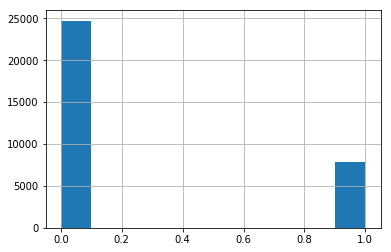

In [11]:
df.Target.hist()

## Validation set
Since we're fitting our model to data, we want to have an unbiased estimate of its performance to help optimise the architecture before we apply the model to the testing data. We can randomly sample a *validation* set from the training data.

In [12]:
from sklearn.model_selection import train_test_split

_, val_ids = train_test_split(df.index, stratify=df.Target, test_size=0.2, random_state=0)

To help reduce code overhead in the next step, we'll simply set flag in the data for whether or not we want to use each row for training or validation.

In [13]:
df['val'] = 0
df.loc[val_ids, 'val'] = 1

# Feature processing
The data contains both continuous features (real values with numerical comparison) and categorical features (discreet values or string labels with no numerical comparison). Each need to be treated slightly differently.

In [14]:
cat_feats = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']
cont_feats = ['Age', 'fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
train_feats = cont_feats+cat_feats

## Categorical encoding
Our model can only function on numbers, but the categorical features use strings. We can map these string values to integers in order to feed the data into our model. We also want to know whether there are categories which only appear in either training or testing

In [15]:
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    print(feat, set(df[feat]) == set(df_test[feat]))

WorkClass True
Education True
MaritalStatus True
Occupation True
Relationship True
Race True
Gender True
NativeCountry False


In [16]:
print('Missing from test:',  [f for f in set(df.NativeCountry) if f not in set(df_test.NativeCountry)])
print('Missing from train:', [f for f in set(df_test.NativeCountry) if f not in set(df.NativeCountry)])

Missing from test: [' Holand-Netherlands']
Missing from train: []


So, the training data contains an extra country which doesn't appear in the testing data, however the model may well be able to learn things from the extra data which are invarient to country, so we'll keep it in.

We need to ensure the same string --> integer mapping is applied to both training and testing, in order to make sure the data still has the same meaning when we apply the model to the testing data. We'll also construct dictionaries to keep track of the mapping. **N.B.** Pandas has a dedicated column type `Categorical` for helping with this kind of data, but we'll stick with integer mapping for now.

In [17]:
cat_maps = defaultdict(dict)
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    for i, val in enumerate(set(df[feat])):
        cat_maps[feat][val] = i
        df.loc[df[feat] == val, feat] = i
        df_test.loc[df_test[feat] == val, feat] = i

In [18]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target,val
0,39,1,77516,7,13,3,3,0,3,0,2174,0,40,28,0,0
1,50,0,83311,7,13,1,4,2,3,0,0,0,13,28,0,0
2,38,2,215646,2,9,6,5,0,3,0,0,0,40,28,0,0
3,53,2,234721,13,7,1,5,2,4,0,0,0,40,28,0,0
4,28,2,338409,7,13,1,0,1,4,1,0,0,40,25,0,0


Looks good, our data now only contains numerical information

## Continuous preprocessing
The weight initialisation we use is optimal for inputs which are unit-Gaussian. The closest we can get is to shift and scale each feature to have mean zero and standard deviation one. `SK-Learn` has `Pipeline` classes to handle series of transformations to data, and we'll use the `StandardScaler` to transform the data.

In [19]:
from lumin.data_processing.pre_proc import fit_input_pipe

input_pipe = fit_input_pipe(df[df.val == 0], cont_feats=cont_feats, savename=PATH/'input_pipe', norm_in=True)

And finally apply the transformation to the training, validation, and testing data.

In [20]:
df[cont_feats] = input_pipe.transform(df[cont_feats].values.astype('float32'))
df_test[cont_feats] = input_pipe.transform(df_test[cont_feats].values.astype('float32'))

We can check the transformation by plotting an example feature

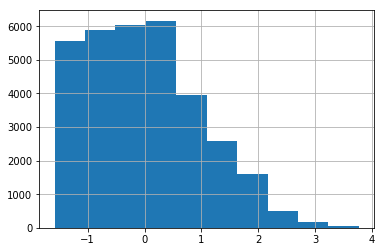

In [21]:
df.Age.hist()

## Data weighting
As seen earlier the data contains a class imbalance which will bias the classifier toward identifying one class better than the other. This is dangerous since we don't know what the class populations will be like in the testing dataset, or any other dataset we later apply the model to. Instead we want to balance the classes in order to get a model which classifies both classes equally well. There are several ways to go about this, but since LUMIN is designed with physics data in mind (which are normally accompanied by weights) we'll go with modifying the weights for training to balance the classes. These weights get passed to the loss function in order to increase the penalty for miss-classifying under-represented classes.

In [22]:
df['weight'] = 1
df.loc[(df.val==0)&(df.Target==0), 'weight'] = 1/len(df[(df.val==0)&(df.Target==0)])
df.loc[(df.val==0)&(df.Target==1), 'weight'] = 1/len(df[(df.val==0)&(df.Target==1)])
print(df.loc[(df.val==0)&(df.Target==0), 'weight'].sum(), df.loc[(df.val==0)&(df.Target==1), 'weight'].sum())

1.0 0.9999999999999997


So now in the training data the total weighted sum of both classes are equal

## Saving to foldfile

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.
These split the data into subsamples (folds).

In [23]:
from lumin.data_processing.file_proc import df2foldfile

df2foldfile(df=df[df.val==0], n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats='Target',
            wgt_feat='weight', savename=PATH/'train', targ_type='int')

Saving fold 0 with 2605 events
Saving fold 1 with 2605 events
Saving fold 2 with 2605 events
Saving fold 3 with 2605 events
Saving fold 4 with 2605 events
Saving fold 5 with 2605 events
Saving fold 6 with 2605 events
Saving fold 7 with 2605 events
Saving fold 8 with 2604 events
Saving fold 9 with 2604 events


In [24]:
df2foldfile(df=df[df.val==1], n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats='Target',
            savename=PATH/'val', targ_type='int')

Saving fold 0 with 652 events
Saving fold 1 with 652 events
Saving fold 2 with 652 events
Saving fold 3 with 651 events
Saving fold 4 with 651 events
Saving fold 5 with 651 events
Saving fold 6 with 651 events
Saving fold 7 with 651 events
Saving fold 8 with 651 events
Saving fold 9 with 651 events


In [25]:
df2foldfile(df=df_test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats='Target',
            savename=PATH/'test', targ_type='int')

Saving fold 0 with 1629 events
Saving fold 1 with 1628 events
Saving fold 2 with 1628 events
Saving fold 3 with 1628 events
Saving fold 4 with 1628 events
Saving fold 5 with 1628 events
Saving fold 6 with 1628 events
Saving fold 7 with 1628 events
Saving fold 8 with 1628 events
Saving fold 9 with 1628 events


The data can now be interfaced to via `FoldYielder` objects

In [26]:
from lumin.nn.data.fold_yielder import FoldYielder

train_fy = FoldYielder(PATH/'train.hdf5')
train_fy

FoldYielder with 10 folds, containing ['inputs', 'targets', 'weights']

# Model training

## Model specification
Here we define the architecture of the models, and how we want to train them. `ModelBuilder` takes arguments to define the network, loss, optimiser, and inputs and outputs and can then create networks on demand. These networks are provided as properties of the `Model` class which contains methods to train them, evaluate, predict, save/load, et cetera.
### ModelBuilder
Most of the parameters will use default values if not provided explicitly which can be viewed in the source code, e.g. `ModelBuilder._parse_loss`, `ModelBuilder._parse_model_args`, and `ModelBuilder._parse_opt_args`.
#### Architecture
The network consists of three parts: A head, which takes the inputs to the network; a body, which contains the majority of the hidden layers; and a tail which downscales the output of the body to match the desired number of outputs. The classes used for each can be specified 

By default the head is `CatEmbHead` which provides [entity embeddings](https://arxiv.org/abs/1604.06737) for categorical features (embedding sizes can be configured manually, or left as default `max(50,cardinality//2)`), and then a batch normalisation with the continuous inputs, with separate dropouts for embeddings and continuous inputs. More advanced classes, can be passed to the `ModelBuilder` head argument, or `ModelBuilder.get_head` overridden in an inheriting class. An `CatEmbedder` class is needed to provide the necessary parameters for the embeddings. They can either be instantiated from the training `FoldYielder`, or by manually providing the required information.

The default body is a simple sequence of hidden layers (`FullyConnected`). These layers can optionally have dropout, batch normalisation, skip connections (residual network), or cumulative concatenations (dense network). The choice of class is set by `ModelBuldier`'s `body` argument, and built by `ModelBuilder.get_body`.

The tail (default `ClassRegMulti` set by `tail` argument/`ModelBuilder.get_tail`) uses a final dense layer to scale down the body output to match `n_out` and then applies an automatically selected activation according to `objective`:
- 'class*' or 'labelclass*' = sigmoid
- 'multiclass' = logsoftmax
- 'regression' and not `y_range` = linear
- 'regression' and `y_range` = sigmoid + offset and rescaling
#### Loss
This can either be passed as the `loss` argument of `ModelBuilder`, or be left to be automatically chosen according to `objective`:
- 'class*' or 'labelclass*' = Binary cross-entropy (`nn.BCELoss`)
- 'multiclass' = Weighted cross-entropy (`WeightedCCE`)
- 'regression' = Weighted mean-squared error (`WeightedMSE`, (`WeightedMAE` also exists but must be explicitly passed))

**N.B.** If a loss class is passed explicitly, it should be uninitialised to allow weights to be correctly handled.

`ModelBuilder.parse_loss` handles the automatic loss configuration.
#### Optimiser
Configured by `opt_args` argument of `ModelBuilder`, `ModelBuidler._parse_opt_args`, and `ModelBuilder._build_opt`. Currently only SGD and Adam are available by passing string representations, however more exotic optimisers can be set by passing uninstanciated classes as the `opt_args['opt']` parameter. Choices of weight decay should be added in `opt_args`. The Learning rate can be set later via `ModelBuilder.set_lr`.

#### Architecture
For our example architecture we'll use relu-based 2-layer network of widths 100 and a bit of dropout and $L_2$ regularisation.

In [27]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.helpers import CatEmbedder

bs = 64
objective = 'classification'
model_args = {'body':{'act':'relu', 'width':100, 'depth':2, 'do':0.20}}
opt_args = {'opt':'adam', 'eps':1e-08, 'weight_decay':1e-7}
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

/home/giles/cernbox/lumin/lumin/nn/models/model_builder.py:202: UserWarning: According to arXiv:1711.05101, AdamW is recommended when using weight decay (L2) regularisation; continuing with Adam.
  warnings.warn('According to arXiv:1711.05101, AdamW is recommended when using weight decay (L2) regularisation; continuing with Adam.')


Inputs:
6 Continuous: ['Age', 'fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
                   
8  Categorical: ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Gender', 'NativeCountry']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(9, 5)
      (1): Embedding(16, 8)
      (2): Embedding(7, 4)
      (3): Embedding(15, 8)
      (4): Embedding(6, 3)
      (5): Embedding(5, 3)
      (6): Embedding(2, 1)
      (7): Embedding(42, 21)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=59, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)


## Training

### Learning rate optimisation
The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `fold_lr_find`, runs several trainings using different folds of the data and then plots the mean and standard deviation of the loss.

LR finder took 1.390s 


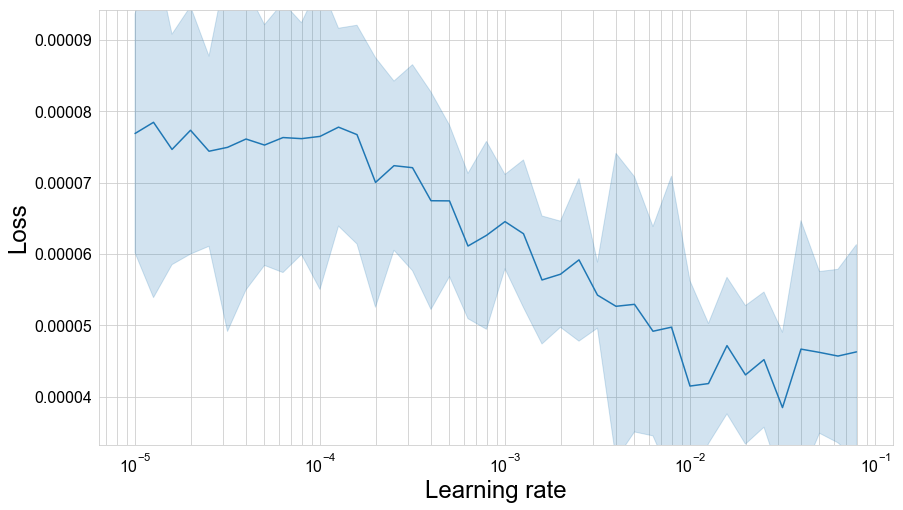

In [28]:
from lumin.optimisation.hyper_param import lr_find

lr_finder = lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

Looks like around 1e-3 should be about reasonable

In [29]:
model_builder.set_lr(1e-3)

`train_models` is the main training loop for LUMIN, and trains a specified number of models (even just one) using $k-1$ folds of data for training and the $k$th fold for validation.
We'll train the model for 30 epochs ($30\times9$ training folds).

### Training

During training, it can be useful to get feedback on the model performance in terms of realistic metrics. In the this example of binary classification, the accuracy and area under the receiver operator characteristic curve are useful metrics. We can add `Eval` classes, which will be called on the validation folds after a model has been trained.

In [30]:
from lumin.nn.metrics.class_eval import BinaryAccuracy, RocAucScore

eval_metrics = {'Accuracy':BinaryAccuracy(), 'AUC':RocAucScore()}

Training model 1 / 1, Val ID = 0


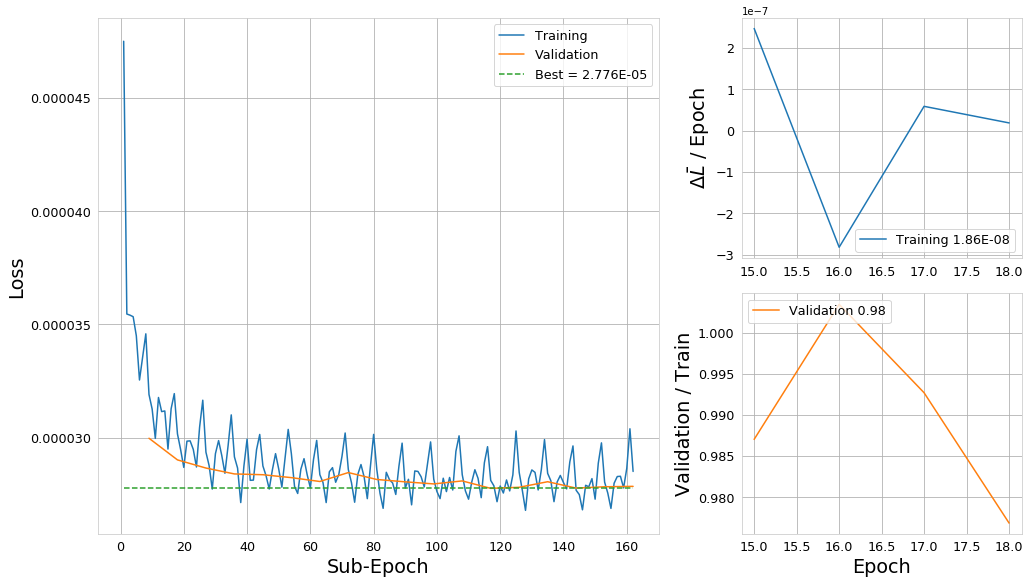

Early stopping
Loading best model with loss 2.776E-05
Model took 30.547s

Scores are: {'loss': 2.775700886559207e-05, 'Accuracy': 0.8092130518234165, 'AUC': 0.9152479091995221}

______________________________________
Training finished
Cross-validation took 30.659s 


<Figure size 1024x576 with 0 Axes>

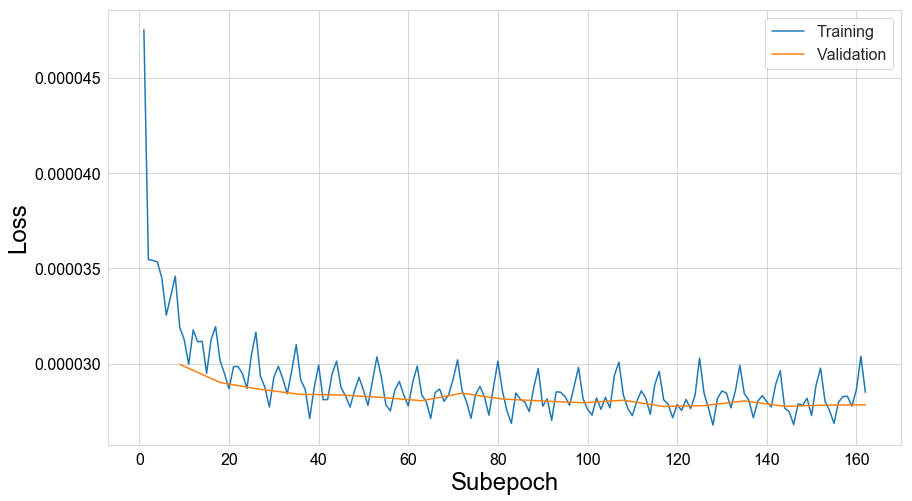

Mean loss = 2.775700886559207e-05±0.0
Mean Accuracy = 0.8092130518234165±0.0
Mean AUC = 0.9152479091995221±0.0
______________________________________



In [76]:
from lumin.nn.training.train import train_models

results, histories, cycle_losses = train_models(train_fy,  # Training data
                                                n_models=1,  # Number of models to train
                                                model_builder=model_builder,  # How to build models, losses, and optimisers
                                                bs=bs,  # Batch size
                                                train_on_weights=True,  # Whether to use data weights (if present)
                                                eval_on_weights=True,  # Whether to compute eval_metrics with data weights (if present)
                                                n_epochs=30,  # Maximum number of epochs to train
                                                patience=5,  # If not None, stop training if validation loss doesn't improve after set number of epochs (automatic save best)
                                                eval_metrics=eval_metrics)  # Pass our evaluation metrics

### Loading
Since `train_models` expects to train an arbitrary number of models, it doesn't return trained models, rather it saves the models to be loaded later on. NB the state of the model which gets save is the best performing state as evaluated using the validation fold. Each model gets it's own subdirectory e.g. 'train_weights/model_id_0'

In [77]:
from lumin.nn.models.model import Model

model = Model.from_save('train_weights/model_id_0/train_0.h5', model_builder)

## Prediction and evaluation

### Prediction
LUMIN models can be used to predict on a range of data formats, including `FoldYielders`, in which case the predictions will be saved as a new column in the foldfile.

In [78]:
val_fy = FoldYielder(PATH/'val.hdf5'); val_fy

FoldYielder with 10 folds, containing ['inputs', 'pred', 'targets']

In [79]:
model.predict(val_fy)
val_fy

FoldYielder with 10 folds, containing ['inputs', 'pred', 'targets']

### Evaluation

We can load a Pandas `DataFrame` from the `FoldYielder` using:

In [80]:
val_df = val_fy.get_df(); val_df.head()

6513 datapoints loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:379: UserWarning: weights not found in file
  warnings.warn(f"{wgt_name} not found in file")


,gen_target,pred
0,0,0.660305
1,0,0.062089
2,0,0.003670
3,0,0.012784
4,0,0.493827


Or if we want to include also the input data

In [81]:
val_df = val_fy.get_df(inc_inputs=True); val_df.head()

6513 datapoints loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:379: UserWarning: weights not found in file
  warnings.warn(f"{wgt_name} not found in file")


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,gen_target,pred
0,0.763718,0.034370,-0.414712,-0.146647,-0.212386,-0.032432,2.0,2.0,1.0,10.0,2.0,3.0,0.0,28.0,0,0.660305
1,-1.068748,2.298115,1.130588,-0.146647,-0.212386,-0.032432,2.0,7.0,3.0,7.0,4.0,3.0,0.0,28.0,0,0.062089
2,-0.555658,-0.037158,-0.414712,-0.146647,-0.212386,-0.843567,2.0,2.0,3.0,1.0,3.0,4.0,1.0,28.0,0,0.003670
3,-0.335762,2.784951,-0.414712,-0.146647,-0.212386,-0.032432,2.0,2.0,3.0,5.0,0.0,4.0,0.0,28.0,0,0.012784
4,0.397225,-0.272719,-0.414712,-0.146647,-0.212386,-0.032432,6.0,2.0,1.0,1.0,2.0,4.0,0.0,28.0,0,0.493827


Or if we want the unpreprocessed inputs:

In [82]:
val_fy.add_input_pipe_from_file(PATH/'input_pipe.pkl')
val_df = val_fy.get_df(inc_inputs=True, deprocess=True, nan_to_num=True); val_df.head()

6513 datapoints loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:379: UserWarning: weights not found in file
  warnings.warn(f"{wgt_name} not found in file")


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,gen_target,pred
0,49.0,193366.0,9.0,-0.000058,-8.247994e-07,40.0,2.0,2.0,1.0,10.0,2.0,3.0,0.0,28.0,0,0.660305
1,24.0,432376.0,13.0,-0.000058,-8.247994e-07,40.0,2.0,7.0,3.0,7.0,4.0,3.0,0.0,28.0,0,0.062089
2,31.0,185814.0,9.0,-0.000058,-8.247994e-07,30.0,2.0,2.0,3.0,1.0,3.0,4.0,1.0,28.0,0,0.003670
3,34.0,483777.0,9.0,-0.000058,-8.247994e-07,40.0,2.0,2.0,3.0,5.0,0.0,4.0,0.0,28.0,0,0.012784
4,44.0,160943.0,9.0,-0.000058,-8.247994e-07,40.0,6.0,2.0,1.0,1.0,2.0,4.0,0.0,28.0,0,0.493827


We'll evaluate the model using the accuracy of its predictions

In [83]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=val_df.gen_target, y_pred=val_df.pred.round())

0.8080761553815446

Note we could have loaded data directly via the `FoldYielder.get_column` method

In [84]:
accuracy_score(y_true=val_fy.get_column('targets'), y_pred=val_fy.get_column('pred').round())

0.8080761553815446

We can also plot out the distribution of predictions by class

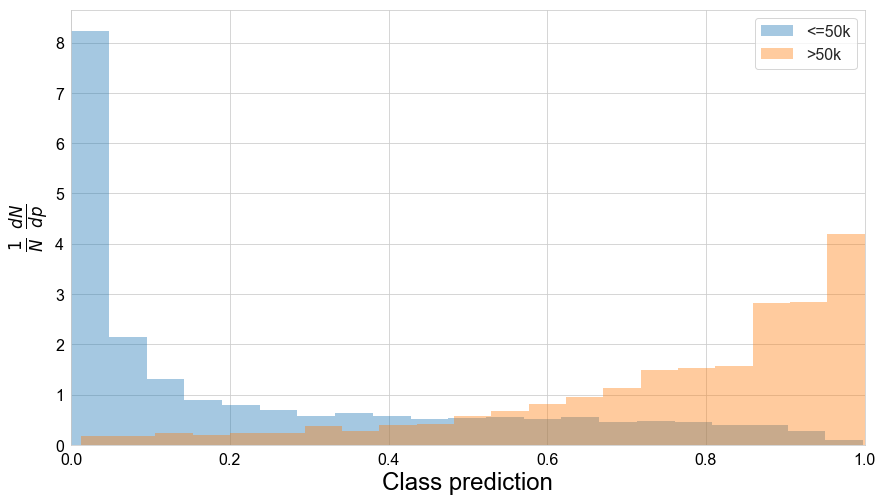

In [85]:
from lumin.plotting.results import plot_binary_class_pred
from lumin.plotting.plot_settings import PlotSettings

plot_binary_class_pred(val_df, settings=PlotSettings(targ2class={0:'<=50k', 1:'>50k'}))

# Interpretation
We can see exactly how important each input feature is to our model by computing the *permutation importance* for each feature. An explanation of PI may be found here [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html). PI is a measure of how much the model degrades when the information carried by a feature is destroyed. A greater degradation implies that the model relies more on the feature.

PI in LUMIN can be computed by a single function, and if we pass it the training data as a `FoldYielder` it will compute the average importance over the folds.

Top ten most important features:
          Feature  Importance  Uncertainty
0    CapitalGain    0.849138     0.153772
1  MaritalStatus    0.581814     0.043054
2            Age    0.190403     0.025275
3   EducationNum    0.189949     0.017339
4     Occupation    0.094189     0.015045
5   HoursPerWeek    0.093180     0.021806
6   Relationship    0.037887     0.006967
7         Gender    0.031211     0.009807
8    CapitalLoss    0.026425     0.010106
9      WorkClass    0.013473     0.003543


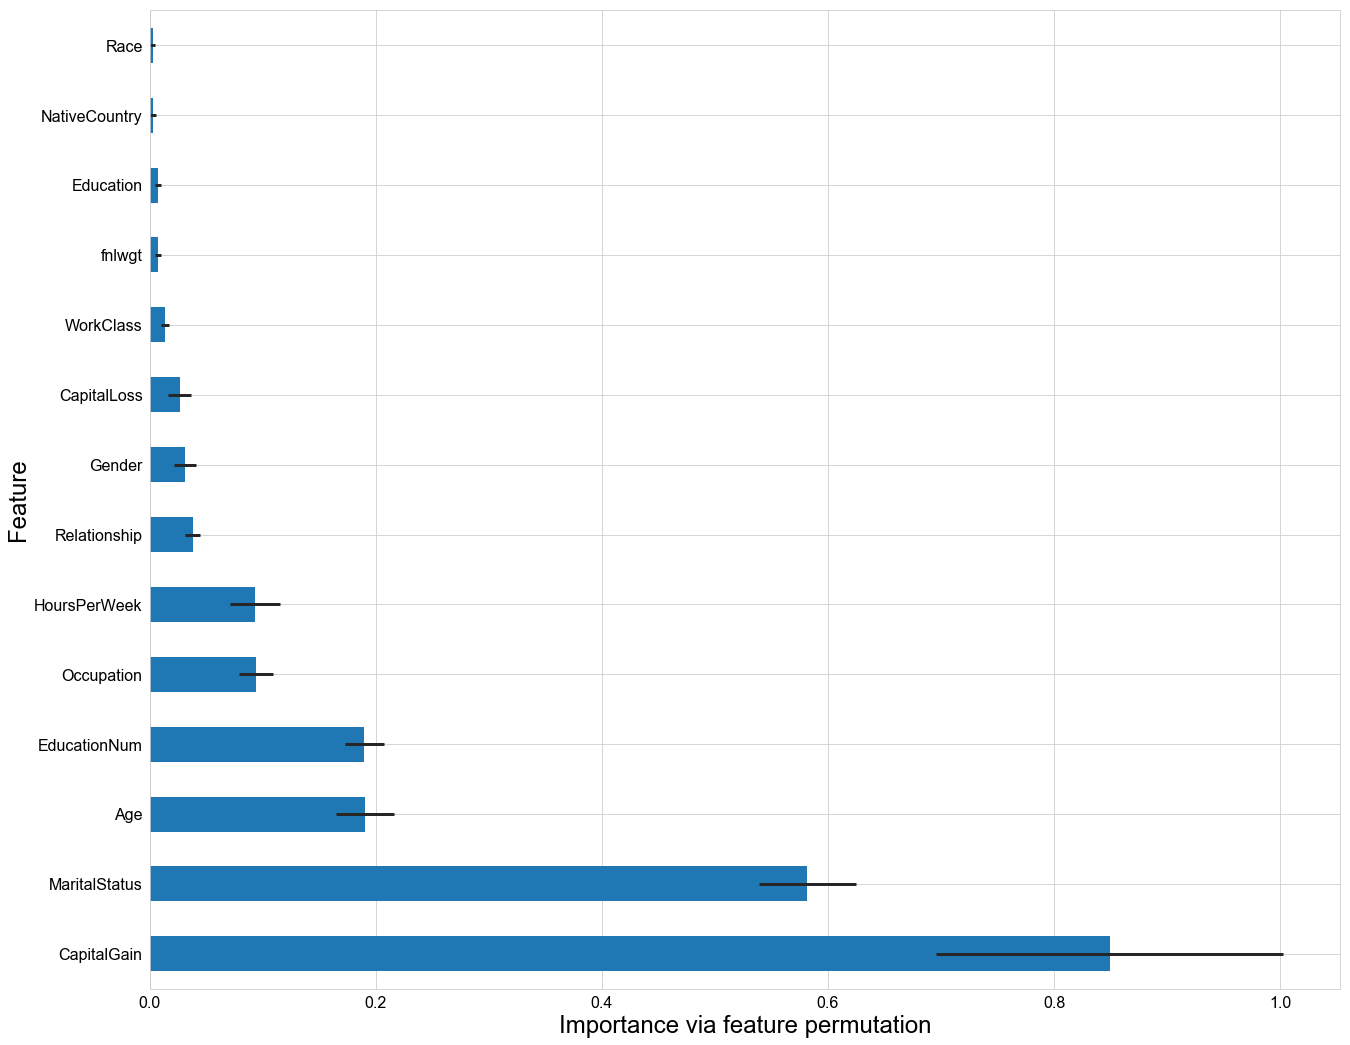

In [86]:
fi = model.get_feat_importance(train_fy)

From this we can see that the model heavily relies on `CapitalGain`, but also uses a range of other features to support its decisions.